In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-6b-100-d/glove.6B.100d.txt
/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
import pandas as pd

In [3]:
dataset=pd.read_csv(r"/kaggle/input/amazon-fine-food-reviews/Reviews.csv")

In [4]:
pd.set_option('display.max_colwidth', None)


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
dataset.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [7]:
print(dataset[['Score','Text']].head(5))

   Score  \
0      5   
1      1   
2      4   
3      2   
4      5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Text  
0                                                                                                                                                                                                                                                        I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed m

In [8]:
print(dataset.isna().sum())

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


In [9]:
lmtpData=dataset[['Text','Summary','Score']].sample(n=1000)
print(lmtpData)

### ADDING SENTIMENT COLUMN

In [10]:
#0-negative, 1-positive
def lblScore(score):
    if score<=2:
        return 0
    elif score>=4:
        return 1
    else:
        return 2
lmtpData['Sentiment']=lmtpData['Score'].apply(lblScore)
lmtpData.head(5)

,Text,Summary,Score,Sentiment
229512,"With the regular order form option for Bob's through Amazon, I am paying 3 dollars less per bag than I would for the cheapest grocery store price in my area!",what a deal,5,1
255819,"My kiddos love these fruit snack pouches and I love that they are mess free, great for a snack in the car because we always on the go",kids love them,5,1
310812,"I think the berry flavor is far better than the veggie powder as far as taste goes but I don't mind either one. I add this to some juice, kefir, some coconut oil whatever, but I always add stevia with it. I think this is a very cheap insurance to staying or getting healthy. I battled with my health my whole life. I try now to stay as natural as I can with my health care now. It leads me to `well' a lot quicker. I was one of those DES babies you may or may not have heard about. Our mothers took DES which was a drug to prevent a miscarriage but what happened was it caused problems with the baby and left a compromised immune system. This is why my whole life it has been one thing after another. Well, THIS powder is fantastic. When I take this consistently I have far more energy and I just seem to stay well. When I get lazy about it and stop taking it I have no energy, I get foggy brained, down in the dumps. Big difference. I figure if I take this in the morning, the rest of the day is covered as far as my fruits and veggies are concerned. What I do eat on top of this is a bonus! If you `really' really can't stand the taste then add the stevia, add fruit, juice whatever, it so worth taking this powder!! Personally I have no problem with the flavor. Five starts from me!",I won't live without this!,5,1
116514,"This product tastes like movie style popcorn that is OVERLY salted, and I understand that popcorn is usually pretty salty but this might be a little too much. I would probably buy this again.",Tastes like popcorn,4,1
177853,"Strong and flavorful and not bitter.<br />We enoyed the colorful package, even more the coffee inside. We will surely order again.",FUN PACKAGE _ GOOD BREW,5,1


In [11]:
lmtpData['Sentiment'].value_counts()

Sentiment
1    790
0    154
2     56
Name: count, dtype: int64

#### VECTORS

In [12]:
import numpy as np

glove_path = "/kaggle/input/glove-6b-100-d/glove.6B.100d.txt"

def loadGloveEmbeddings(filePath, embedding_dim=100):
    embeddingsIndex = {}
    with open(filePath, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddingsIndex[word] = coefs
    return embeddingsIndex

gloveEmbeddings = loadGloveEmbeddings(glove_path)
print("Loaded {} word vectors.".format(len(gloveEmbeddings)))


        

Loaded 400000 word vectors.


#### CREATING EMBEDDING MATRIX

In [13]:
lmtpData['Summary']=lmtpData['Summary'].fillna("")
lmtpData['CombinedText']=lmtpData['Summary'] + " " + lmtpData['Text']


In [14]:
#tokenizing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer=Tokenizer()
tokenizer.fit_on_texts(lmtpData['CombinedText'])
sequences=tokenizer.texts_to_sequences(lmtpData['CombinedText'])

maxLen=100
padded_sequences=pad_sequences(sequences,maxlen=maxLen,padding='post')

In [15]:
embedding_dim=100
vocabSize=len(tokenizer.word_index) + 1

embeddingMatrix=np.zeros((vocabSize,embedding_dim))

for word,i in tokenizer.word_index.items():
    embeddingVector=gloveEmbeddings.get(word)
    if embeddingVector is not None:
        embeddingMatrix[i]=embeddingVector

In [16]:
print("Embedding matrix shape:", embeddingMatrix.shape)


Embedding matrix shape: (7137, 100)


### MAKING THE MODEL

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Input
maxLen=100
X_train = padded_sequences 
y_train = lmtpData["Sentiment"].values  

print("Padded shape:", X_train.shape)  
print("Labels shape:", y_train.shape) 

model = Sequential([
    Input(shape=(maxLen,)),
    Embedding(input_dim=vocabSize,  
              output_dim=embedding_dim, 
              weights=embeddingMatrix, 
             
              trainable=False), 
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.3),
    Dense(3, activation='softmax') 
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Padded shape: (1000, 100)
Labels shape: (1000,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 100)            │         713,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 880,551 (3.36 MB)

 Trainable params: 166,851 (651.76 KB)

 Non-trainable params: 713,700 (2.72 MB)

In [18]:

history=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.3)



Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.7170 - loss: 0.9063 - val_accuracy: 0.8333 - val_loss: 0.5539
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.7829 - loss: 0.6778 - val_accuracy: 0.8333 - val_loss: 0.5858
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.7783 - loss: 0.6730 - val_accuracy: 0.8333 - val_loss: 0.5576
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.7778 - loss: 0.6664 - val_accuracy: 0.8333 - val_loss: 0.5623
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.7841 - loss: 0.6527 - val_accuracy: 0.8333 - val_loss: 0.5798
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.8005 - loss: 0.6259 - val_accuracy: 0.8333 - val_loss: 0.5990
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.7594 - loss: 0.6850 - val_accuracy: 0.8333 - val_loss: 0.5562
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.7877 - loss: 0.6478 - val_accuracy: 0.

#### PLOTTING AND ACCURACY AND LOSS CURVES

In [19]:
import matplotlib.pyplot as plt
accuracy=history.history['accuracy']
valAccuracy=history.history['val_accuracy']
loss = history.history['loss']
valLoss = history.history['val_loss']
epochs_range = range(1, len(accuracy) + 1)

Text(0.5, 1.0, 'Training & Validation Accuracy')

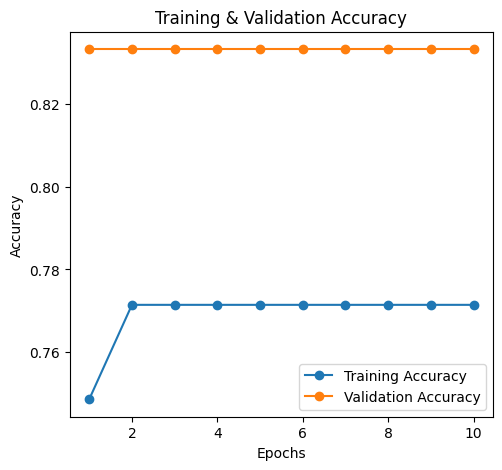

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs_range, valAccuracy, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')

Text(0.5, 1.0, 'Training & Validation Loss')

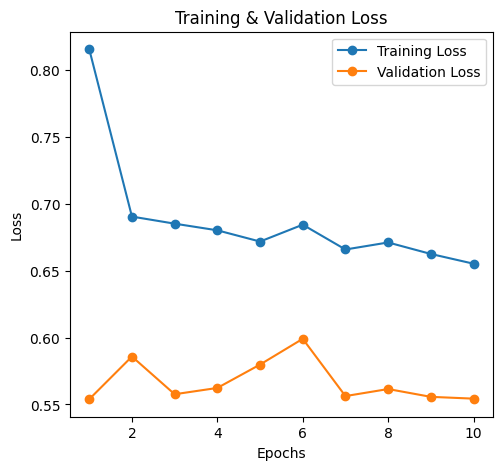

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, valLoss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')

##### overfitting

### OUTPUT VS PREDICTED OUTPUT


In [22]:
predictions = model.predict(padded_sequences)
corrected_classes = np.argmax(predictions, axis=1)
mapping = {0: 1, 1: 2, 2: 0}
predictedClasses = np.array([mapping[i] for i in corrected_classes])


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step


In [23]:

print(predictions[:5])


[[0.15097238 0.809086   0.03994161]
 [0.15097234 0.8090861  0.0399415 ]
 [0.10062347 0.8247269  0.07464966]
 [0.15097356 0.8090832  0.03994323]
 [0.15097205 0.80908686 0.03994107]]


In [24]:

print("Any NaNs in predictions?", np.isnan(predictions).any())
print("Any infinities in predictions?", np.isinf(predictions).any())


Any NaNs in predictions? False
Any infinities in predictions? False


In [25]:
comparisonData=pd.DataFrame({
    "Text":lmtpData["CombinedText"],
    "Actual Sentiment":lmtpData["Sentiment"].values,
    "Predicted Sentiment":predictedClasses
})


In [26]:
comparisonData = comparisonData.iloc[:1000]


In [27]:
comparisonData = comparisonData.copy()

comparisonData["Positive"] = predictions[:, 0] 
comparisonData["Neutral"] = predictions[:, 1]  
comparisonData["Negative"] = predictions[:, 2]



In [28]:
print(comparisonData.describe())
print(comparisonData.dtypes)


       Actual Sentiment  Predicted Sentiment     Positive      Neutral  \
count        1000.00000               1000.0  1000.000000  1000.000000   
mean            0.90200                  2.0     0.141406     0.811175   
std             0.44788                  0.0     0.017712     0.014090   
min             0.00000                  2.0     0.084172     0.719020   
25%             1.00000                  2.0     0.134591     0.809005   
50%             1.00000                  2.0     0.150972     0.809084   
75%             1.00000                  2.0     0.150979     0.809087   
max             2.00000                  2.0     0.191200     0.866750   

          Negative  
count  1000.000000  
mean      0.047419  
std       0.012355  
min       0.038881  
25%       0.039943  
50%       0.039985  
75%       0.054601  
max       0.117968  
Text                    object
Actual Sentiment         int64
Predicted Sentiment      int64
Positive               float32
Neutral             

In [29]:
comparisonData.head(10)

,Text,Actual Sentiment,Predicted Sentiment,Positive,Neutral,Negative
229512,"what a deal With the regular order form option for Bob's through Amazon, I am paying 3 dollars less per bag than I would for the cheapest grocery store price in my area!",1,2,0.150972,0.809086,0.039942
255819,"kids love them My kiddos love these fruit snack pouches and I love that they are mess free, great for a snack in the car because we always on the go",1,2,0.150972,0.809086,0.039942
310812,"I won't live without this! I think the berry flavor is far better than the veggie powder as far as taste goes but I don't mind either one. I add this to some juice, kefir, some coconut oil whatever, but I always add stevia with it. I think this is a very cheap insurance to staying or getting healthy. I battled with my health my whole life. I try now to stay as natural as I can with my health care now. It leads me to `well' a lot quicker. I was one of those DES babies you may or may not have heard about. Our mothers took DES which was a drug to prevent a miscarriage but what happened was it caused problems with the baby and left a compromised immune system. This is why my whole life it has been one thing after another. Well, THIS powder is fantastic. When I take this consistently I have far more energy and I just seem to stay well. When I get lazy about it and stop taking it I have no energy, I get foggy brained, down in the dumps. Big difference. I figure if I take this in the morning, the rest of the day is covered as far as my fruits and veggies are concerned. What I do eat on top of this is a bonus! If you `really' really can't stand the taste then add the stevia, add fruit, juice whatever, it so worth taking this powder!! Personally I have no problem with the flavor. Five starts from me!",1,2,0.100623,0.824727,0.074650
116514,"Tastes like popcorn This product tastes like movie style popcorn that is OVERLY salted, and I understand that popcorn is usually pretty salty but this might be a little too much. I would probably buy this again.",1,2,0.150974,0.809083,0.039943
177853,"FUN PACKAGE _ GOOD BREW Strong and flavorful and not bitter.<br />We enoyed the colorful package, even more the coffee inside. We will surely order again.",1,2,0.150972,0.809087,0.039941
36391,noodles. I was worried at first when I read the other reviews. I followed the directions to the tee amdthe noodles turned out great. Telling all my friends about these.,1,2,0.150972,0.809086,0.039941
308886,"Cats LOVE the food, I hate the mess of packaging...cats win. I've had them try every type of Whiskas. . .this is hands down the best (this, meaning the Purrfectly Chicken, Chicken/Duck, Chicken/Beef). The purple packages don't even resemble meat so even though my cats will eat it, I didn't feel comfortable feeding it to them. The Purrfectly Fish makes a couple of my kitties violently ill (hence the neon pink vomit everywhere) but the Purrfectly chicken varieties seem to agree with all of them. No vomit, they eat a majority of the meat after lapping up all of the juices and grain free. My diabetic cat is no longer diabetic, and the fact that there is now a food in my home that everyone will eat is pretty amazing.<br /><br />My complaint - the packaging. I've tried the tip mentioned by others (storing them upside down) but there is just no way to get the pack open without a) having the juice squirt out on to one of the eager diners (though they don't let that slow them down), b) having the juice squirt and ooze all over my hands c) the juice splattering the wall d) me having to squeeze the package for the remaining bits of meat and juice as if I am milking a cow. I HATE feeding them because I always end up covered in chicken juice and bits and I know there is more in the package that I didn't successfully squeeze out. This in turn means that all of the pets will be trying to go through the trash when they are hungry looking for a few half squeezed packs so they can get another fix. There must be

In [30]:
comparisonData.to_excel("PredictedSample1.xlsx", index=False)


## TRAINING USING NEW SAMPLE DATASET

In [31]:
droppedData=dataset.drop(lmtpData.index)
dataset2=droppedData.sample(1000,random_state=43)
dataset2.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150179,150180,B004DAQ30O,A1EPP3SUJX24TS,Birdsong,0,0,5,1345766400,DELICIOUS IS RIGHT!!!,This makes a WONDERFUL gift!! (Especially for yourself!) ;) Very yummy and vegan!! Yippeee!! I can't wait to order more.
541140,541141,B000FMTJJQ,A3KLPMF6GT7UFR,Allison Pugh,0,0,5,1176249600,Madhave Agave Nectar,"This is a great product at a great price. The light, amber colored nectar reminds me of butterscotch and the darker variety is more like maple syrup. Both blend easily in liquids and taste great on cream of rice cereal. It's low on the glycemic index and doesn't require much."
480335,480336,B000DZDJ0K,AC9M02L4P8PEB,CJR,0,0,5,1336262400,Gluten free and yummy,"This is our G-F go-to ""flour"" for baking. We use it for muffins, for pancakes and waffles, for pie crust, cookies and more. It makes gluten-free baking easy and delicious and our wheat loving family and friends don't know/care that they're eating G-F. This works just fine when substituted in our old favorite ""wheat flour"" recipes. It's a little pricey but has become our favorite brand, worth the cost because it doesn't disappoint. Buying by Amazon subscription is a bargain."
363020,363021,B004I4E37U,A3KOFPXR9MDM5A,"Crazy Cat Lady ""Ida""",1,11,2,1301788800,Like chewing on tinfoil.,"Tastes like generic spearmint without as much as a hint of white tea, or anything else for that matter. The first time I had a piece, I clamped down with my molars and thought I had accidentally taken in some of the foil from the blister pack. Nope. I've since had six more pieces, pretty much just to freshen my breath and then I throw it out. The sensation of biting on something metallic has occurred repeatedly with this gum and no other. Even if it didn't do that, the taste is nothing special and I definitely would not buy this product again."
555897,555898,B002SF035W,A1W31DCPASN65V,"CB ""CB""",2,2,5,1258934400,Excellent Tea,I really enjoyed this rich and flavorful tea. It's so hard to get a tea with this kind of blend in the United States. Lipton and Tetly seem so bland in comparison. Highly recommended.


In [32]:
lmtpData2=dataset2[['Score','Summary','Text']]
lmtpData2.head()

,Score,Summary,Text
150179,5,DELICIOUS IS RIGHT!!!,This makes a WONDERFUL gift!! (Especially for yourself!) ;) Very yummy and vegan!! Yippeee!! I can't wait to order more.
541140,5,Madhave Agave Nectar,"This is a great product at a great price. The light, amber colored nectar reminds me of butterscotch and the darker variety is more like maple syrup. Both blend easily in liquids and taste great on cream of rice cereal. It's low on the glycemic index and doesn't require much."
480335,5,Gluten free and yummy,"This is our G-F go-to ""flour"" for baking. We use it for muffins, for pancakes and waffles, for pie crust, cookies and more. It makes gluten-free baking easy and delicious and our wheat loving family and friends don't know/care that they're eating G-F. This works just fine when substituted in our old favorite ""wheat flour"" recipes. It's a little pricey but has become our favorite brand, worth the cost because it doesn't disappoint. Buying by Amazon subscription is a bargain."
363020,2,Like chewing on tinfoil.,"Tastes like generic spearmint without as much as a hint of white tea, or anything else for that matter. The first time I had a piece, I clamped down with my molars and thought I had accidentally taken in some of the foil from the blister pack. Nope. I've since had six more pieces, pretty much just to freshen my breath and then I throw it out. The sensation of biting on something metallic has occurred repeatedly with this gum and no other. Even if it didn't do that, the taste is nothing special and I definitely would not buy this product again."
555897,5,Excellent Tea,I really enjoyed this rich and flavorful tea. It's so hard to get a tea with this kind of blend in the United States. Lipton and Tetly seem so bland in comparison. Highly recommended.


In [33]:
lmtpData2 = lmtpData2.copy()
lmtpData2['Summary'] = lmtpData2['Summary'].fillna("")
lmtpData2['CombinedText'] = lmtpData2['Summary'] + " " + lmtpData2['Text']


In [34]:
lmtpData2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 150179 to 28987
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Score         1000 non-null   int64 
 1   Summary       1000 non-null   object
 2   Text          1000 non-null   object
 3   CombinedText  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.1+ KB


In [35]:

lmtpData2['Sentiment']=lmtpData2['Score'].apply(lblScore)
lmtpData2.head(5)

,Score,Summary,Text,CombinedText,Sentiment
150179,5,DELICIOUS IS RIGHT!!!,This makes a WONDERFUL gift!! (Especially for yourself!) ;) Very yummy and vegan!! Yippeee!! I can't wait to order more.,DELICIOUS IS RIGHT!!! This makes a WONDERFUL gift!! (Especially for yourself!) ;) Very yummy and vegan!! Yippeee!! I can't wait to order more.,1
541140,5,Madhave Agave Nectar,"This is a great product at a great price. The light, amber colored nectar reminds me of butterscotch and the darker variety is more like maple syrup. Both blend easily in liquids and taste great on cream of rice cereal. It's low on the glycemic index and doesn't require much.","Madhave Agave Nectar This is a great product at a great price. The light, amber colored nectar reminds me of butterscotch and the darker variety is more like maple syrup. Both blend easily in liquids and taste great on cream of rice cereal. It's low on the glycemic index and doesn't require much.",1
480335,5,Gluten free and yummy,"This is our G-F go-to ""flour"" for baking. We use it for muffins, for pancakes and waffles, for pie crust, cookies and more. It makes gluten-free baking easy and delicious and our wheat loving family and friends don't know/care that they're eating G-F. This works just fine when substituted in our old favorite ""wheat flour"" recipes. It's a little pricey but has become our favorite brand, worth the cost because it doesn't disappoint. Buying by Amazon subscription is a bargain.","Gluten free and yummy This is our G-F go-to ""flour"" for baking. We use it for muffins, for pancakes and waffles, for pie crust, cookies and more. It makes gluten-free baking easy and delicious and our wheat loving family and friends don't know/care that they're eating G-F. This works just fine when substituted in our old favorite ""wheat flour"" recipes. It's a little pricey but has become our favorite brand, worth the cost because it doesn't disappoint. Buying by Amazon subscription is a bargain.",1
363020,2,Like chewing on tinfoil.,"Tastes like generic spearmint without as much as a hint of white tea, or anything else for that matter. The first time I had a piece, I clamped down with my molars and thought I had accidentally taken in some of the foil from the blister pack. Nope. I've since had six more pieces, pretty much just to freshen my breath and then I throw it out. The sensation of biting on something metallic has occurred repeatedly with this gum and no other. Even if it didn't do that, the taste is nothing special and I definitely would not buy this product again.","Like chewing on tinfoil. Tastes like generic spearmint without as much as a hint of white tea, or anything else for that matter. The first time I had a piece, I clamped down with my molars and thought I had accidentally taken in some of the foil from the blister pack. Nope. I've since had six more pieces, pretty much just to freshen my breath and then I throw it out. The sensation of biting on something metallic has occurred repeatedly with this gum and no other. Even if it didn't do that, the taste is nothing special and I definitely would not buy this product again.",0
555897,5,Excellent Tea,I really enjoyed this rich and flavorful tea. It's so hard to get a tea with this kind of blend in the United States. Lipton and Tetly seem so bland in comparison. Highly recommended.,Excellent Tea I really enjoyed this rich and flavorful tea. It's so hard to get a tea with this kind of blend in the United States. Lipton and Tetly seem so bland in comparison. Highly recommended.,1


In [36]:
tokenizer.fit_on_texts(lmtpData2['CombinedText'])
sequences=tokenizer.texts_to_sequences(lmtpData2['CombinedText'])

maxLen=100
paddedData=pad_sequences(sequences,maxlen=maxLen,padding='post')
embedding_dim=100
vocabSize=len(tokenizer.word_index) + 1

embeddingMatrix2=np.zeros((vocabSize,embedding_dim))

for word,i in tokenizer.word_index.items():
    embeddingVector2=gloveEmbeddings.get(word)
    if embeddingVector2 is not None:
        embeddingMatrix2[i]=embeddingVector2

### BALANCING THE CLASSES

In [37]:
from imblearn.over_sampling import SMOTE


y2 = lmtpData2['Sentiment'].values


smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(paddedData, y2)


In [38]:
maxLen=100
model = Sequential([
    Input(shape=(maxLen,)),
    Embedding(input_dim=vocabSize,  
              output_dim=embedding_dim, 
              weights=embeddingMatrix2, 
             
              trainable=False), 
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.6),
    Dense(3, activation='softmax') 
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 100)            │       1,005,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,172,451 (4.47 MB)

 Trainable params: 166,851 (651.76 KB)

 Non-trainable params: 1,005,600 (3.84 MB)

In [39]:
model.fit(X_resampled, Y_resampled, epochs=6, batch_size=32, validation_split=0.3)

Epoch 1/6
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.5290 - loss: 0.9572 - val_accuracy: 0.0000e+00 - val_loss: 2.8275
Epoch 2/6
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.5480 - loss: 0.8738 - val_accuracy: 0.0000e+00 - val_loss: 3.1948
Epoch 3/6
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.5280 - loss: 0.8536 - val_accuracy: 0.0000e+00 - val_loss: 2.9046
Epoch 4/6
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.5443 - loss: 0.8450 - val_accuracy: 0.0000e+00 - val_loss: 2.8248
Epoch 5/6
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.5640 - loss: 0.8365 - val_accuracy: 0.0000e+00 - val_loss: 3.1234
Epoch 6/6
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.5963 - loss: 0.8205 - val_accuracy: 0.0000e+00 - val_loss: 3.0760


In [40]:
model.fit(X_resampled, Y_resampled, epochs=15, batch_size=32, validation_split=0.4)

Epoch 1/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.5867 - loss: 0.8405 - val_accuracy: 0.1090 - val_loss: 2.3032
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.6219 - loss: 0.8150 - val_accuracy: 0.1132 - val_loss: 2.6924
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.6405 - loss: 0.7969 - val_accuracy: 0.1506 - val_loss: 2.6002
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.6902 - loss: 0.7381 - val_accuracy: 0.1848 - val_loss: 2.6820
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.6794 - loss: 0.7300 - val_accuracy: 0.1795 - val_loss: 2.4873
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - accuracy: 0.7495 - loss: 0.6558 - val_accuracy: 0.1934 - val_loss: 2.8129
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.7826 - loss: 0.5927 - val_accuracy: 0.2276 - val_loss: 3.2740
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.8161 - loss: 0.5302 - val_accuracy: 0.

In [41]:
model.fit(X_resampled, Y_resampled, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.7745 - loss: 0.6943 - val_accuracy: 0.0043 - val_loss: 1.3440
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.7989 - loss: 0.5323 - val_accuracy: 0.0000e+00 - val_loss: 1.5971
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.8008 - loss: 0.5193 - val_accuracy: 0.0021 - val_loss: 1.5640
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.7914 - loss: 0.5207 - val_accuracy: 0.0000e+00 - val_loss: 1.3656
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.7867 - loss: 0.5628 - val_accuracy: 0.0214 - val_loss: 1.2426
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.8306 - loss: 0.4509 - val_accuracy: 0.0021 - val_loss: 1.4926
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.8466 - loss: 0.3966 - val_accuracy: 0.0021 - val_loss: 1.6647
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.8250 - loss: 0.4525 - va

### WITHOUT SMOTE

In [42]:
model.fit(paddedData,y2, epochs=15, batch_size=32, validation_split=0.3)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.9505 - loss: 0.1138 - val_accuracy: 0.9867 - val_loss: 0.0508
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.9616 - loss: 0.0835 - val_accuracy: 0.9700 - val_loss: 0.0676
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.9597 - loss: 0.0800 - val_accuracy: 0.9833 - val_loss: 0.0444
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.9716 - loss: 0.0790 - val_accuracy: 0.9700 - val_loss: 0.0741
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.9752 - loss: 0.0592 - val_accuracy: 0.9667 - val_loss: 0.0583
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.9821 - loss: 0.0547 - val_accuracy: 0.9833 - val_loss: 0.0509
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.9762 - loss: 0.0523 - val_accuracy: 0.9833 - val_loss: 0.0538
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.9840 - loss: 0.0624 - val_accuracy: 0.

#### PREDICTING DATA


In [43]:
predictedData=model.predict(paddedData)

corrected_classes2 = np.argmax(predictedData, axis=1)
mapping = {0: 1, 1: 2, 2: 0}
predClasses= np.array([mapping[i] for i in corrected_classes2])

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step


In [44]:
comparisonData2=pd.DataFrame({
    "Text":lmtpData["CombinedText"],
    "Actual Sentiment":lmtpData["Sentiment"].values,
    "Predicted Sentiment":predClasses
})


comparisonData2["Positive"] = predictedData[:, 0] 
comparisonData2["Neutral"] = predictedData[:, 1]  
comparisonData2["Negative"] = predictedData[:, 2]

In [45]:
comparisonData2.tail(10)

,Text,Actual Sentiment,Predicted Sentiment,Positive,Neutral,Negative
431733,"Good Coffee Rich, somewhat strong flavor. Great aroma.<br /><br />I am a coffee drinker and I totally enjoyed it.<br /><br />Thank you.<br />MEF",1,2,0.000362,0.999488,0.000150
204480,"Best Steel Cut Oats out there! First of all, whoever eats regular quaker rolled oats, BELIEVE ME, once you try Steel Cut oats, you can never go back to that mushy gooey bowl of quick cooking oats. Initially when I switched over, I used to buy the McCann's 5 minute Steel Cut Oats which are pretty good, but once I discovered these, there was no going back! The size of each grain is larger in these, and when cooked and plumped up, it has a great texture (the McCann's one in comparison is smaller and tastes slightly gritty when cooked). To speed up the cooking time, I usually do this the night before:<br /><br />Pour cold water over oats (+1tsp whole wheat flour/wheat or oat bran) the night before to abt 1"" above the level of oats in ur bowl... then microwave for 1.5 - 2 minutes (check that it doesnt overflow!)... then boil some water in a kettle and pour enough water to fill your bowl 1/2 way or 2/3 of the way to the top... then cover and let soak overnight... the next morning, add a little more water (if necessary) and microwave again for 2-3 minutes (again, check to make sure it doesnt overflow)... then add ur toppings and flavourings and Enjoy!!!! I do this every other morning and eat my oats at work, and it's well worth the little extra prep time the night before - trust me!!!",1,2,0.002698,0.863095,0.134208
477057,"Smokin- from beginning to.... My favorite Salsa if a bit overpriced here. Gives things a kick, but is thick enough to also put on tortilla chips. Mrs Renfro isn't like some of the wussy companies putting out boring, tasteless salsas though its still pretty far from ""gourmet"".<br /><br />I recommend their Nacho cheese sauce as well (way better than the canned crap Campbells or anyone else puts out).<br /><br /> I have some really interesting bathroom stories from this stuff.. hehhehee..",1,2,0.000342,0.999485,0.000173
277851,Great selection I love the variety of coffee I received in this package. All different brands so I can sample and see what I do and do not like. The only disappointment was the packaging. It arrived loose inside a brown paper bag which was stapled shut. Not impressed by that but overall very pleased with the coffee.,1,2,0.000705,0.999090,0.000205
461609,"Great alternative My son can't have sugar due to an enamel deficiency and this is a treat that is fine for his condition. He gets left out of so much, and it is nice that he can be allowed to chew gum.",1,2,0.000677,0.999138,0.000185
276224,"Neat container horrible hot chocolate First off, each can only makes two 6oz servings. So this is a rather expensive cup of hot chocolate. The flavor, at least to me, is terrible, it is mostly sugar and red dye. It is a novel idea that might appeal to small kids but adults will find it sickeningly sweet. As mentioned above, it is rather expensive for what it is. Only thing I like about this are the coffin shaped cans.",0,2,0.000963,0.998763,0.000274
521914,My dogs love this stuff Fast Delivery. My dogs love this stuff. This is the best deal I found on this item anywhere. I will buy more.,1,2,0.000216,0.999659,0.000125
279384,"Chai low carb Very sweet for a diabetic. I actually bought it for my mom, but she did not like it very much. The service, however, was excellent--prompt shipping.",2,0,0.002806,0.000817,0.996377
414745,"Amazing Taste! Tried it three different ways: black, just cream and cream & sugar. This was such a smooth flavor that I enjoyed drinking it all three ways, which has never happened before. I also love the pod design; I used my regular coffee machine, so the pods make clean up quick & easy.",1,2,0.003378,0.995003,0.001619
188261,"yumm I have had a cup of coffee like this befor and loved it. I have been trying different coffee a

In [46]:
comparisonData2.to_excel('PredictedSample2.xlsx')

#### USING A SPECIFIC REVIEW

In [47]:

new_review = "I love this product, it's amazing!"


new_review_tokens = tokenizer.texts_to_sequences([new_review])
new_review_padded = pad_sequences(new_review_tokens, maxlen=maxLen)

predictions = model.predict(new_review_padded)


predicted_class = np.argmax(predictions, axis=1)

print("Predicted Class: ", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Class:  [0]
